In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from skimage import io, img_as_ubyte
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = []

In [3]:
def calculate_glcm_properties_per_rgb_channel(image_list, label):
    contrast_r, contrast_g, contrast_b = [], [], []
    correlation_r, correlation_g, correlation_b = [], [], []
    homogeneity_r, homogeneity_g, homogeneity_b = [], [], []
    dissimilarity_r, dissimilarity_g, dissimilarity_b = [], [], []
    energy_r, energy_g, energy_b = [], [], []
    
    for img_path in image_list:
        image = io.imread(img_path)
        
        # Pisahkan channel warna
        red_channel = image[:, :, 0]
        green_channel = image[:, :, 1]
        blue_channel = image[:, :, 2]
        
        # Menghitung GLCM untuk setiap channel
        def glcm_props(channel):
            image = img_as_ubyte(channel)

            bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
            inds = np.digitize(image, bins)

            max_value = inds.max()+1
            glcm = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, symmetric=False, normed=False)

            contrast = graycoprops(glcm, 'contrast')
            correlation = graycoprops(glcm, 'correlation')
            homogeneity = graycoprops(glcm, 'homogeneity')
            dissimilarity = graycoprops(glcm, 'dissimilarity')
            energy = graycoprops(glcm, 'energy')

            return contrast, correlation, homogeneity, dissimilarity, energy

        # Ekstraksi properti untuk tiap channel
        c_r, co_r, h_r, d_r, e_r = glcm_props(red_channel)
        c_g, co_g, h_g, d_g, e_g = glcm_props(green_channel)
        c_b, co_b, h_b, d_b, e_b = glcm_props(blue_channel)

        row = {
            'filepath': img_path,
            'label': label,
            'type': 'rgb',
            'rgb_contrast_r': np.mean(c_r),
            'rgb_correlation_r': np.mean(co_r),
            'rgb_homogeneity_r': np.mean(h_r),
            'rgb_dissimilarity_r': np.mean(d_r),
            'rgb_energy_r': np.mean(e_r),
            'rgb_contrast_g': np.mean(c_g),
            'rgb_correlation_g': np.mean(co_g),
            'rgb_homogeneity_g': np.mean(h_g),
            'rgb_dissimilarity_g': np.mean(d_g),
            'rgb_energy_g': np.mean(e_g),
            'rgb_contrast_b': np.mean(c_b),
            'rgb_correlation_b': np.mean(co_b),
            'rgb_homogeneity_b': np.mean(h_b),
            'rgb_dissimilarity_b': np.mean(d_b),
            'rgb_energy_b': np.mean(e_b)
        }

        data.append(row)
        
        contrast_r.append(c_r)
        correlation_r.append(co_r)
        homogeneity_r.append(h_r)
        dissimilarity_r.append(d_r)
        energy_r.append(e_r)
        
        contrast_g.append(c_g)
        correlation_g.append(co_g)
        homogeneity_g.append(h_g)
        dissimilarity_g.append(d_g)
        energy_g.append(e_g)
        
        contrast_b.append(c_b)
        correlation_b.append(co_b)
        homogeneity_b.append(h_b)
        dissimilarity_b.append(d_b)
        energy_b.append(e_b)
    
    # Mengembalikan rata-rata dari setiap properti
    return (np.mean(contrast_r), np.mean(correlation_r), np.mean(homogeneity_r), np.mean(dissimilarity_r), np.mean(energy_r),
            np.mean(contrast_g), np.mean(correlation_g), np.mean(homogeneity_g), np.mean(dissimilarity_g), np.mean(energy_g),
            np.mean(contrast_b), np.mean(correlation_b), np.mean(homogeneity_b), np.mean(dissimilarity_b), np.mean(energy_b))

In [4]:
base_dir = 'data/'

sessions = [
    [os.path.join(base_dir, 'branded', 'rgb', f'branded_{i}.jpg') for i in range(1, 31)],
    [os.path.join(base_dir, 'unbranded', 'rgb', f'unbranded_{i}.jpg') for i in range(1, 31)],
]

In [5]:
avg_contrast_r, avg_correlation_r, avg_homogeneity_r, avg_dissimilarity_r, avg_energy_r = [], [], [], [], []
avg_contrast_g, avg_correlation_g, avg_homogeneity_g, avg_dissimilarity_g, avg_energy_g = [], [], [], [], []
avg_contrast_b, avg_correlation_b, avg_homogeneity_b, avg_dissimilarity_b, avg_energy_b = [], [], [], [], []

avg_contrast_r, avg_correlation_r, avg_homogeneity_r, avg_dissimilarity_r, avg_energy_r = [], [], [], [], []
avg_contrast_g, avg_correlation_g, avg_homogeneity_g, avg_dissimilarity_g, avg_energy_g = [], [], [], [], []
avg_contrast_b, avg_correlation_b, avg_homogeneity_b, avg_dissimilarity_b, avg_energy_b = [], [], [], [], []

for session in sessions:
    label = 'Saus ABC' if sessions.index(session) == 0 else 'Saus Tradisional'

    c_r, co_r, h_r, d_r, e_r, c_g, co_g, h_g, d_g, e_g, c_b, co_b, h_b, d_b, e_b = calculate_glcm_properties_per_rgb_channel(session, label=label)
    
    avg_contrast_r.append(c_r)
    avg_correlation_r.append(co_r)
    avg_homogeneity_r.append(h_r)
    avg_dissimilarity_r.append(d_r)
    avg_energy_r.append(e_r)
    
    avg_contrast_g.append(c_g)
    avg_correlation_g.append(co_g)
    avg_homogeneity_g.append(h_g)
    avg_dissimilarity_g.append(d_g)
    avg_energy_g.append(e_g)
    
    avg_contrast_b.append(c_b)
    avg_correlation_b.append(co_b)
    avg_homogeneity_b.append(h_b)
    avg_dissimilarity_b.append(d_b)
    avg_energy_b.append(e_b)

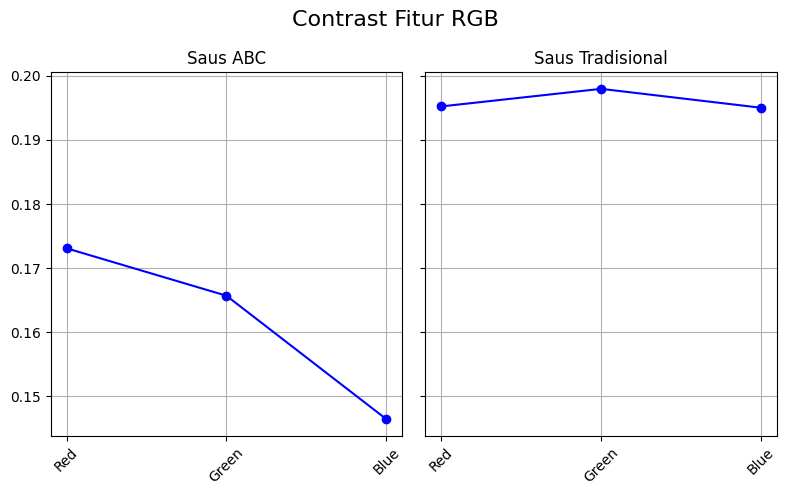

In [6]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_contrast_r[i], avg_contrast_g[i], avg_contrast_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Contrast Fitur RGB', fontsize=16)
plt.tight_layout()
plt.show()

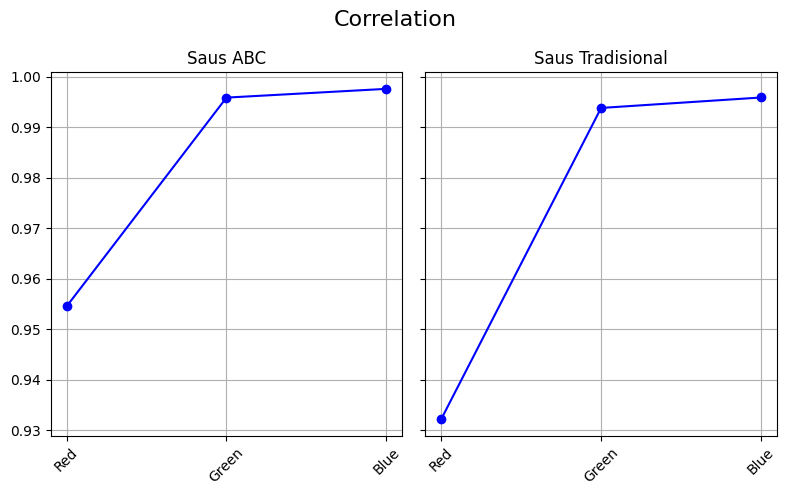

In [7]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_correlation_r[i], avg_correlation_g[i], avg_correlation_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Correlation', fontsize=16)
plt.tight_layout()
plt.show()

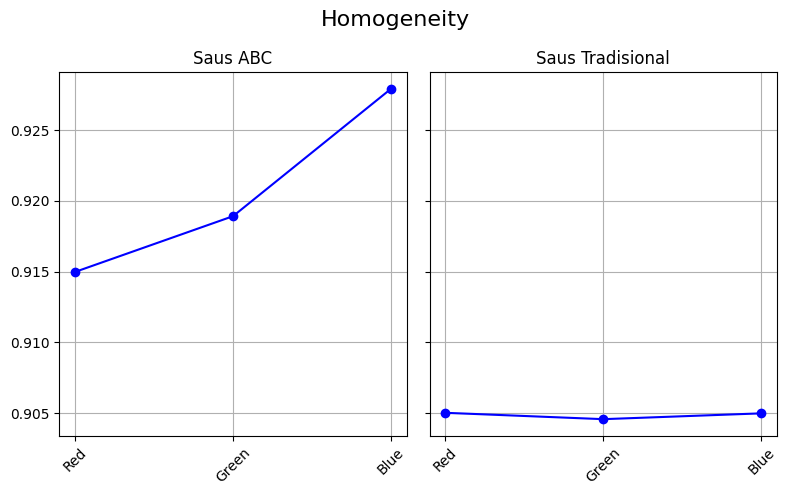

In [8]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_homogeneity_r[i], avg_homogeneity_g[i], avg_homogeneity_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Homogeneity', fontsize=16)
plt.tight_layout()
plt.show()

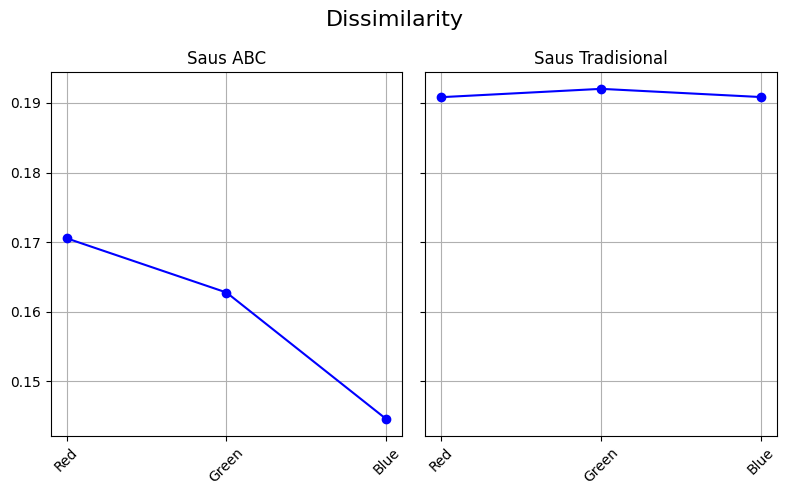

In [9]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_dissimilarity_r[i], avg_dissimilarity_g[i], avg_dissimilarity_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Dissimilarity', fontsize=16)
plt.tight_layout()
plt.show()

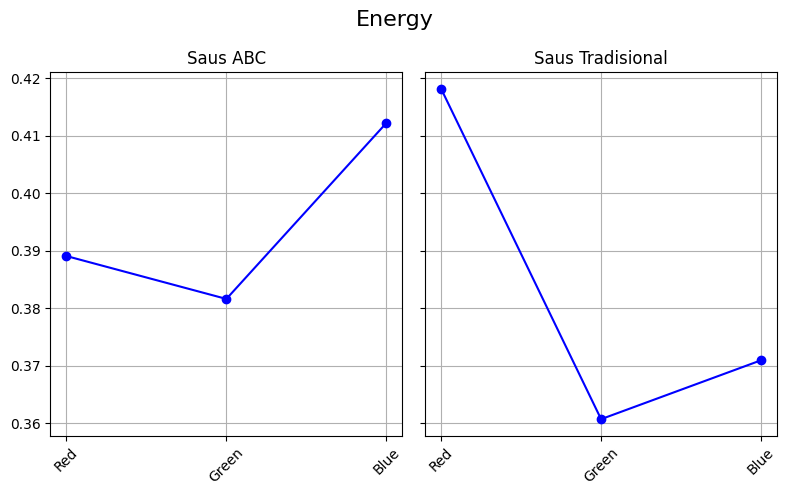

In [10]:
x_labels = ['Red', 'Green', 'Blue']
sessions_labels = ['Saus ABC', 'Saus Tradisional']

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

for i, label in enumerate(sessions_labels):
    axs[i].plot(x_labels, [avg_energy_r[i], avg_energy_g[i], avg_energy_b[i]], marker='o', label='Contrast', color='blue')
    axs[i].set_title(label)
    axs[i].set_xticks(np.arange(len(x_labels)))
    axs[i].set_xticklabels(x_labels, rotation=45)
    axs[i].grid(True)

# Label dan judul untuk seluruh figure
fig.suptitle('Energy', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
# ABC
std_contrast_r = avg_contrast_r[0]
std_contrast_g = avg_contrast_g[0]
std_contrast_b = avg_contrast_b[0]

std_correlation_r = avg_correlation_r[0]
std_correlation_g = avg_correlation_g[0]
std_correlation_b = avg_correlation_b[0]

std_homogeneity_r = avg_homogeneity_r[0]
std_homogeneity_g = avg_homogeneity_g[0]
std_homogeneity_b = avg_homogeneity_b[0]

std_dissimilarity_r = avg_dissimilarity_r[0]
std_dissimilarity_g = avg_dissimilarity_g[0]
std_dissimilarity_b = avg_dissimilarity_b[0]

std_energy_r = avg_energy_r[0]
std_energy_g = avg_energy_g[0]
std_energy_b = avg_energy_b[0]

print("\t\t\tStandar Deviasi\n")
print("\t\tRed\t\tGreen\t\tBlue")
print("Contrast \t{:}\t{:}\t{:}".format(std_contrast_r, std_contrast_g, std_contrast_b))
print("Correlation \t{:}\t{:}\t{:}".format(std_correlation_r, std_correlation_g, std_correlation_b))
print("Homogeneity \t{:}\t{:}\t{:}".format(std_homogeneity_r, std_homogeneity_g, std_homogeneity_b))
print("Dissimilarity \t{:}\t{:}\t{:}".format(std_dissimilarity_r, std_dissimilarity_g, std_dissimilarity_b))
print("Energy \t\t{:}\t{:}\t{:}".format(std_energy_r, std_energy_g, std_energy_b))

			Standar Deviasi

		Red		Green		Blue
Contrast 	0.17310332403476025	0.16570387247204918	0.14644929408437016
Correlation 	0.9544917895147459	0.995832068882357	0.9975658268781376
Homogeneity 	0.9149770442748376	0.9189127192274469	0.9279078903367824
Dissimilarity 	0.17055500157023754	0.1627621232396179	0.1445612137324537
Energy 		0.38908705885708367	0.381626833198142	0.41221898995480794


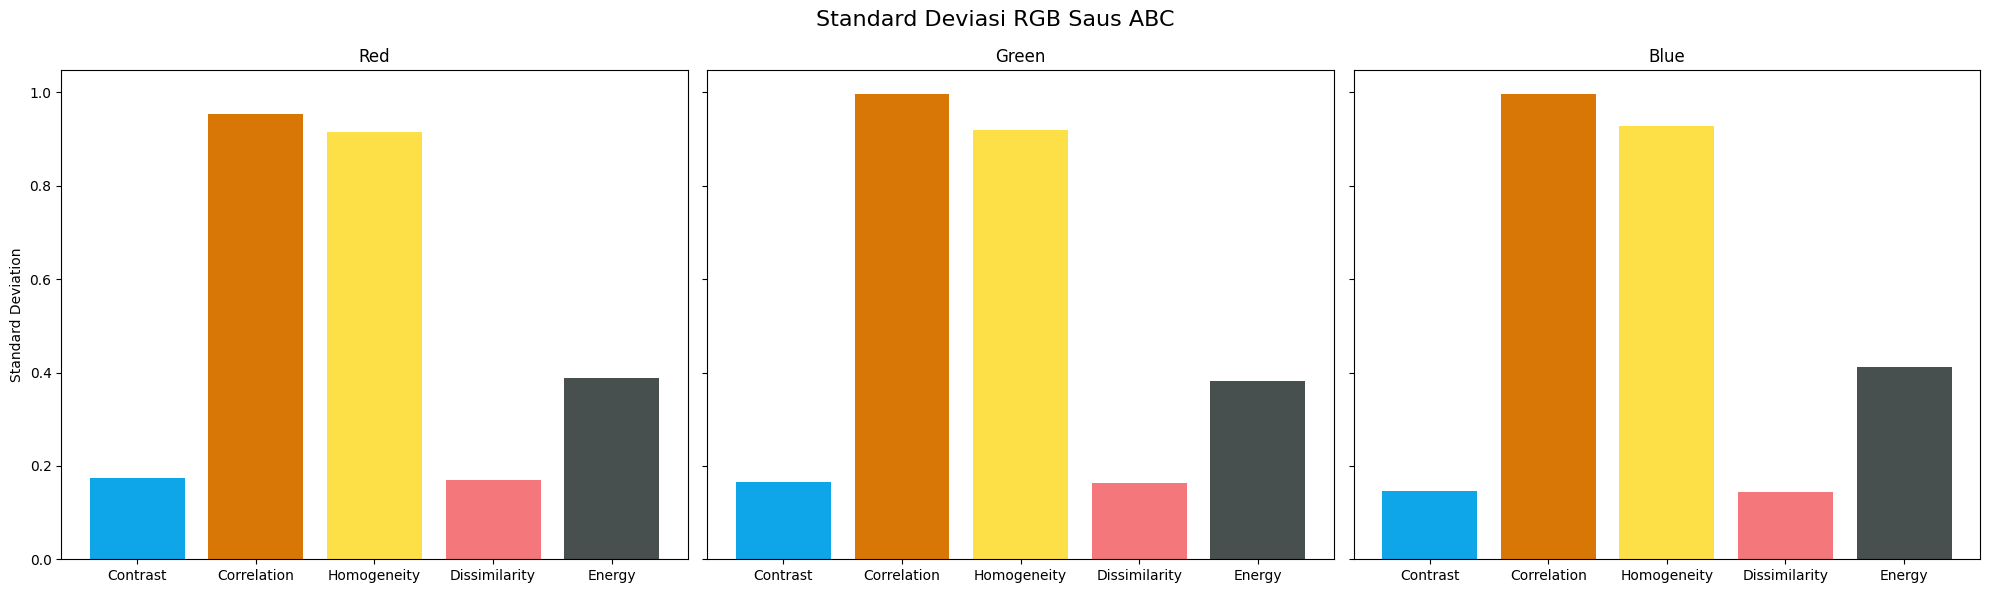

In [12]:
red_values = [std_contrast_r, std_correlation_r, std_homogeneity_r, std_dissimilarity_r, std_energy_r]
green_values = [std_contrast_g, std_correlation_g, std_homogeneity_g, std_dissimilarity_g, std_energy_g]
blue_values = [std_contrast_b, std_correlation_b, std_homogeneity_b, std_dissimilarity_b, std_energy_b]

labels = ['Contrast', 'Correlation', 'Homogeneity', 'Dissimilarity', 'Energy']
colors = ['#0ea5e9', '#d97706', '#fde047', '#f3777b', '#484f4f']

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot untuk channel Red
axes[0].bar(labels, red_values, color=colors)
axes[0].set_title('Red')
axes[0].set_ylabel('Standard Deviation')

# Plot untuk channel Green
axes[1].bar(labels, green_values, color=colors)
axes[1].set_title('Green')

# Plot untuk channel Blue
axes[2].bar(labels, blue_values, color=colors)
axes[2].set_title('Blue')

plt.suptitle('Standard Deviasi RGB Saus ABC', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
# ABC
std_contrast_r = avg_contrast_r[1]
std_contrast_g = avg_contrast_g[1]
std_contrast_b = avg_contrast_b[1]

std_correlation_r = avg_correlation_r[1]
std_correlation_g = avg_correlation_g[1]
std_correlation_b = avg_correlation_b[1]

std_homogeneity_r = avg_homogeneity_r[1]
std_homogeneity_g = avg_homogeneity_g[1]
std_homogeneity_b = avg_homogeneity_b[1]

std_dissimilarity_r = avg_dissimilarity_r[1]
std_dissimilarity_g = avg_dissimilarity_g[1]
std_dissimilarity_b = avg_dissimilarity_b[1]

std_energy_r = avg_energy_r[1]
std_energy_g = avg_energy_g[1]
std_energy_b = avg_energy_b[1]

print("\t\t\tStandar Deviasi\n")
print("\t\tRed\t\tGreen\t\tBlue")
print("Contrast \t{:}\t{:}\t{:}".format(std_contrast_r, std_contrast_g, std_contrast_b))
print("Correlation \t{:}\t{:}\t{:}".format(std_correlation_r, std_correlation_g, std_correlation_b))
print("Homogeneity \t{:}\t{:}\t{:}".format(std_homogeneity_r, std_homogeneity_g, std_homogeneity_b))
print("Dissimilarity \t{:}\t{:}\t{:}".format(std_dissimilarity_r, std_dissimilarity_g, std_dissimilarity_b))
print("Energy \t\t{:}\t{:}\t{:}".format(std_energy_r, std_energy_g, std_energy_b))

			Standar Deviasi

		Red		Green		Blue
Contrast 	0.19523670619503328	0.19797889492851165	0.1950316105490274
Correlation 	0.932172717002349	0.9937871325458735	0.9958532401423555
Homogeneity 	0.9050231857991252	0.9045739656736534	0.9049841211678675
Dissimilarity 	0.19083140012258534	0.19202732013491325	0.19084858527772094
Energy 		0.4181695274180087	0.3607154109929833	0.3709543233092012


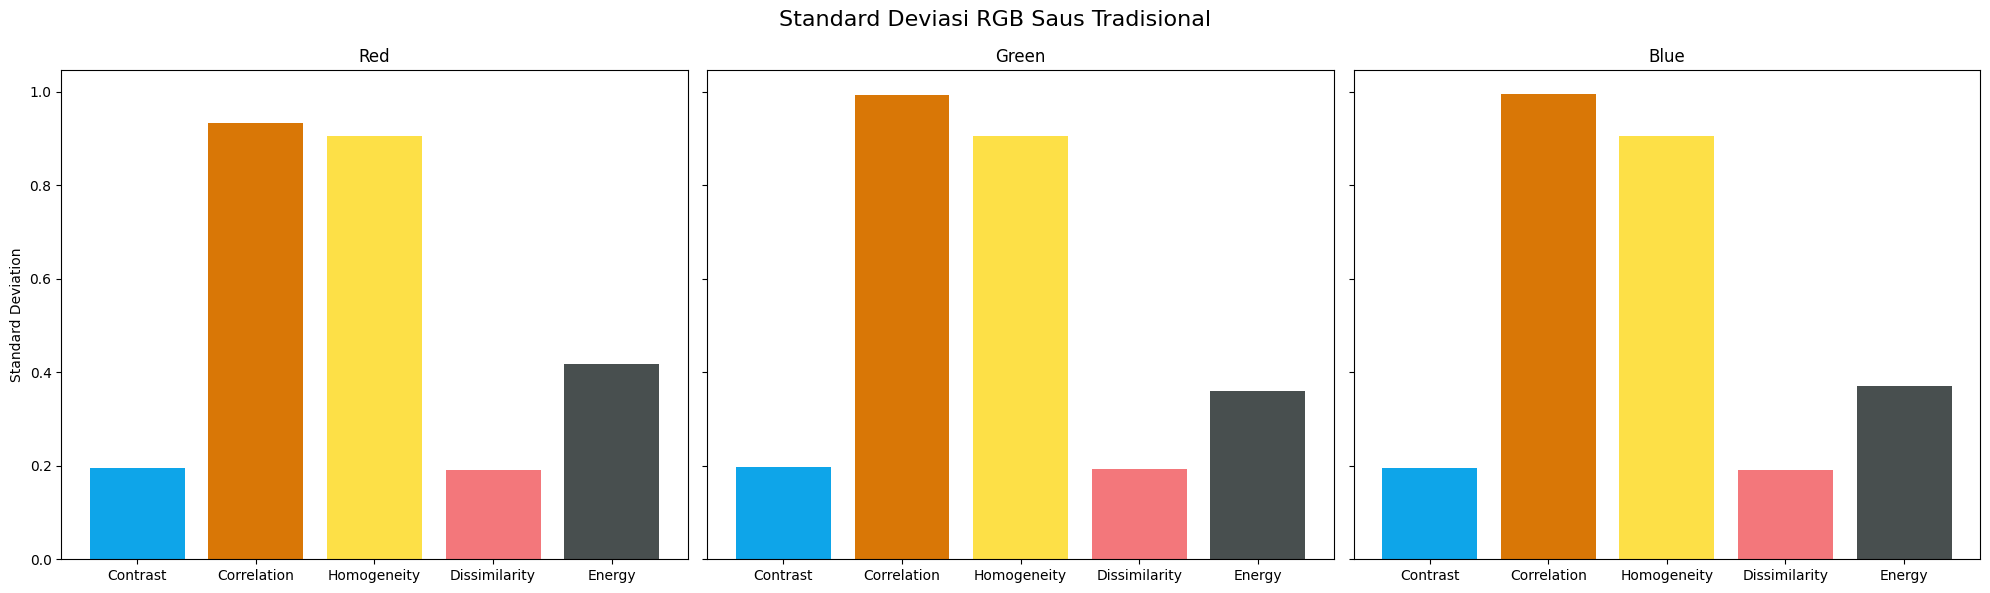

In [14]:
red_values = [std_contrast_r, std_correlation_r, std_homogeneity_r, std_dissimilarity_r, std_energy_r]
green_values = [std_contrast_g, std_correlation_g, std_homogeneity_g, std_dissimilarity_g, std_energy_g]
blue_values = [std_contrast_b, std_correlation_b, std_homogeneity_b, std_dissimilarity_b, std_energy_b]

labels = ['Contrast', 'Correlation', 'Homogeneity', 'Dissimilarity', 'Energy']
colors = ['#0ea5e9', '#d97706', '#fde047', '#f3777b', '#484f4f']

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot untuk channel Red
axes[0].bar(labels, red_values, color=colors)
axes[0].set_title('Red')
axes[0].set_ylabel('Standard Deviation')

# Plot untuk channel Green
axes[1].bar(labels, green_values, color=colors)
axes[1].set_title('Green')

# Plot untuk channel Blue
axes[2].bar(labels, blue_values, color=colors)
axes[2].set_title('Blue')

plt.suptitle('Standard Deviasi RGB Saus Tradisional', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
def calculate_glcm_properties_nir_channel(image_list):
    contrast_list, correlation_list, homogeneity_list, dissimilarity_list, energy_list = [], [], [], [], []
    
    for img_path in image_list:
        image = io.imread(img_path, as_gray=True)
        
        image = img_as_ubyte(image)

        bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
        inds = np.digitize(image, bins)

        max_value = inds.max()+1
        glcm = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, symmetric=False, normed=False)

        contrast = graycoprops(glcm, 'contrast')
        correlation = graycoprops(glcm, 'correlation')
        homogeneity = graycoprops(glcm, 'homogeneity')
        dissimilarity = graycoprops(glcm, 'dissimilarity')
        energy = graycoprops(glcm, 'energy')

        contrast_list.append(contrast)
        correlation_list.append(correlation)
        homogeneity_list.append(homogeneity)
        dissimilarity_list.append(dissimilarity)
        energy_list.append(energy)
    
    # Mengembalikan rata-rata dari setiap properti
    return (np.mean(contrast_list), np.mean(correlation_list), np.mean(homogeneity_list), np.mean(dissimilarity_list), np.mean(energy_list))

In [16]:
base_dir = 'data/'

sessions = [
    [os.path.join(base_dir, 'branded', 'nir', f'branded_{i}.jpg') for i in range(1, 16)],
    [os.path.join(base_dir, 'unbranded', 'nir', f'unbranded_{i}.jpg') for i in range(1, 16)],
]

In [17]:
avg_contrast, avg_correlation, avg_homogeneity, avg_dissimilarity, avg_energy = [], [], [], [], []

for session in sessions:
    c, co, h, d, e = calculate_glcm_properties_nir_channel(session)
    
    avg_contrast.append(c)
    avg_correlation.append(co)
    avg_homogeneity.append(h)
    avg_dissimilarity.append(d)
    avg_energy.append(e)

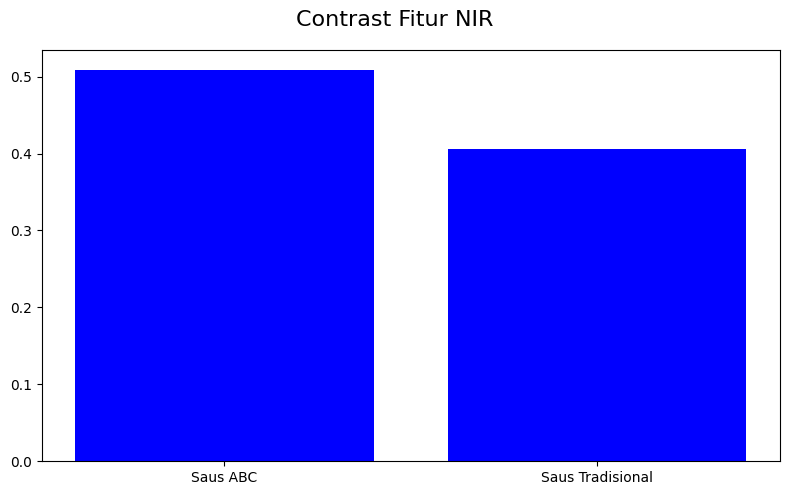

In [18]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_contrast[0], avg_contrast[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Contrast Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

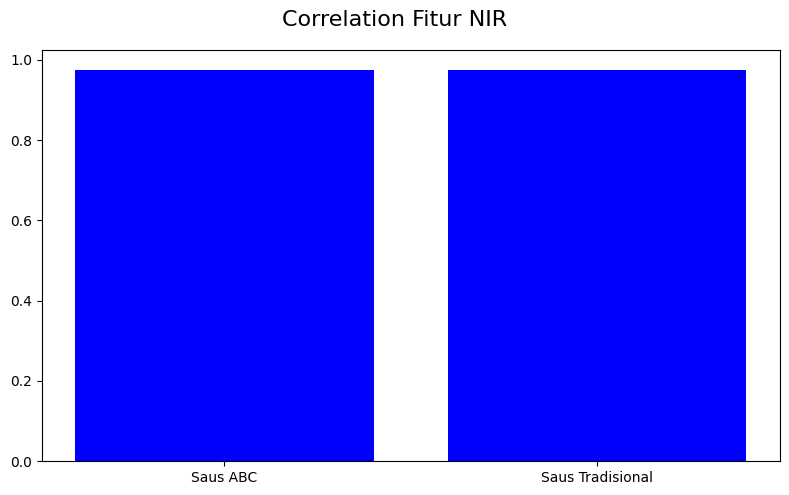

In [19]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_correlation[0], avg_correlation[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Correlation Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

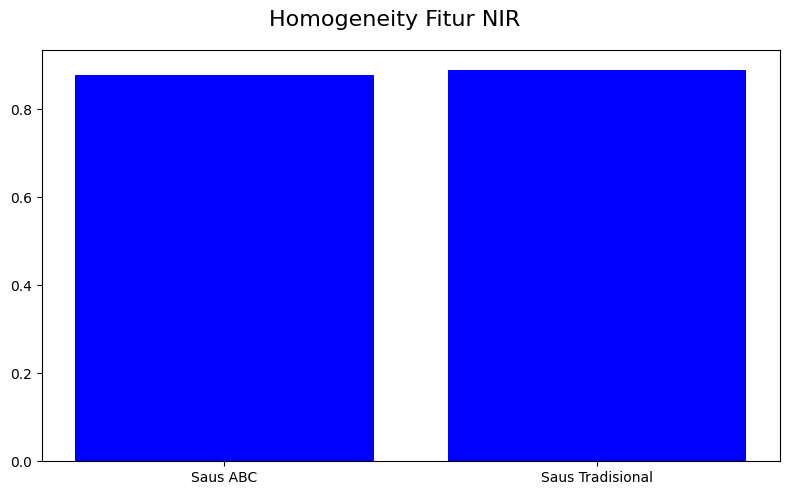

In [20]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_homogeneity[0], avg_homogeneity[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Homogeneity Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

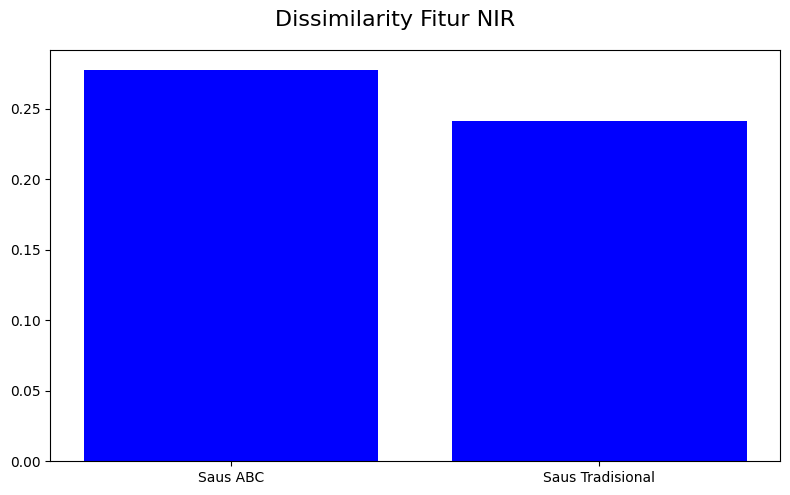

In [21]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_dissimilarity[0], avg_dissimilarity[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Dissimilarity Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

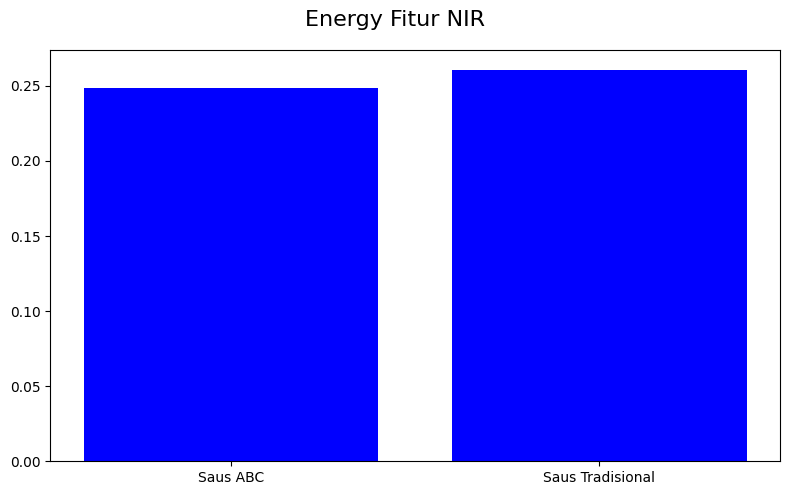

In [22]:
x_labels = ['Saus ABC', 'Saus Tradisional']

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_labels, [avg_energy[0], avg_energy[1]], color='blue')
ax.set_xticks(np.arange(len(x_labels)))

# Label dan judul untuk seluruh figure
fig.suptitle('Energy Fitur NIR', fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
std_contrast_branded = avg_contrast[0]
std_correlation_branded = avg_correlation[0]
std_homogeneity_branded = avg_homogeneity[0]
std_dissimilarity_branded = avg_dissimilarity[0]
std_energy_branded = avg_energy[0]

std_contrast_unbranded = avg_contrast[1]
std_correlation_unbranded = avg_correlation[1]
std_homogeneity_unbranded = avg_homogeneity[1]
std_dissimilarity_unbranded = avg_dissimilarity[1]
std_energy_unbranded = avg_energy[1]

print("\t\t\tStandar Deviasi\n")
print("\t\t\tSaus ABC\t\t\tSaus Tradisional")
print("Contrast \t\t{:}\t\t{:}".format(std_contrast_branded, std_contrast_unbranded))
print("Correlation \t\t{:}\t\t{:}".format(std_correlation_branded, std_correlation_unbranded))
print("Homogeneity \t\t{:}\t\t{:}".format(std_homogeneity_branded, std_homogeneity_unbranded))
print("Dissimilarity \t\t{:}\t\t{:}".format(std_dissimilarity_branded, std_dissimilarity_unbranded))
print("Energy \t\t\t{:}\t\t{:}".format(std_energy_branded, std_energy_unbranded))

			Standar Deviasi

			Saus ABC			Saus Tradisional
Contrast 		0.5091730374158401		0.40607886519871844
Correlation 		0.9737333225343328		0.9753897509742443
Homogeneity 		0.8784903393697798		0.890464219096469
Dissimilarity 		0.2776190135218383		0.24104126247536517
Energy 			0.2483412844223931		0.2608714444295848


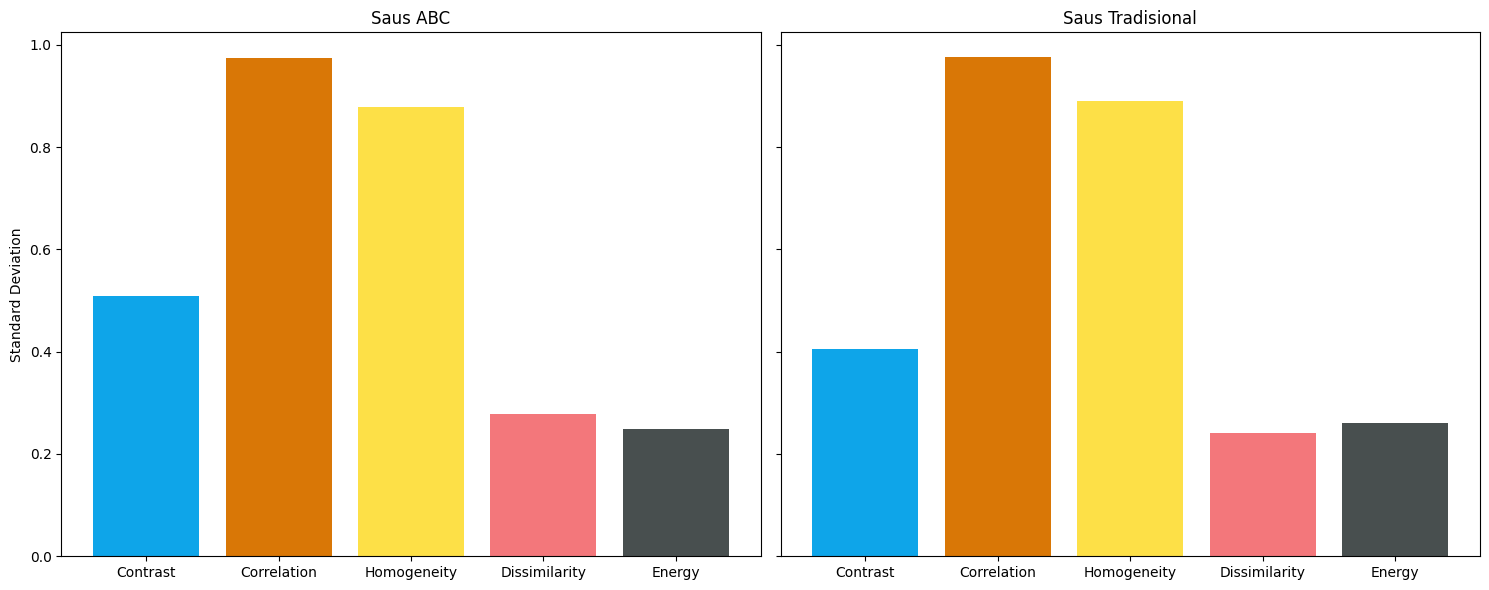

In [24]:
branded_values = [std_contrast_branded, std_correlation_branded, std_homogeneity_branded, std_dissimilarity_branded, std_energy_branded]
unbranded_values = [std_contrast_unbranded, std_correlation_unbranded, std_homogeneity_unbranded, std_dissimilarity_unbranded, std_energy_unbranded]

labels = ['Contrast', 'Correlation', 'Homogeneity', 'Dissimilarity', 'Energy']
colors = ['#0ea5e9', '#d97706', '#fde047', '#f3777b', '#484f4f']

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axes[0].bar(labels, branded_values, color=colors)
axes[0].set_title('Saus ABC')
axes[0].set_ylabel('Standard Deviation')

axes[1].bar(labels, unbranded_values, color=colors)
axes[1].set_title('Saus Tradisional')

plt.tight_layout()

plt.show()

In [25]:
df = pd.DataFrame(data)
df.head()

,filepath,label,type,rgb_contrast_r,rgb_correlation_r,rgb_homogeneity_r,rgb_dissimilarity_r,rgb_energy_r,rgb_contrast_g,rgb_correlation_g,rgb_homogeneity_g,rgb_dissimilarity_g,rgb_energy_g,rgb_contrast_b,rgb_correlation_b,rgb_homogeneity_b,rgb_dissimilarity_b,rgb_energy_b
0,data/branded\rgb\branded_1.jpg,Saus ABC,rgb,0.172592,0.954883,0.915356,0.169838,0.388025,0.159155,0.996013,0.922301,0.156025,0.380903,0.145324,0.997597,0.928595,0.143229,0.405886
1,data/branded\rgb\branded_2.jpg,Saus ABC,rgb,0.172592,0.954883,0.915356,0.169838,0.388025,0.159155,0.996013,0.922301,0.156025,0.380903,0.145324,0.997597,0.928595,0.143229,0.405886
2,data/branded\rgb\branded_3.jpg,Saus ABC,rgb,0.179184,0.951832,0.911892,0.176709,0.385676,0.172667,0.995711,0.915531,0.169559,0.376204,0.152822,0.997489,0.924760,0.150870,0.407158
3,data/branded\rgb\branded_4.jpg,Saus ABC,rgb,0.179184,0.951832,0.911892,0.176709,0.385676,0.172667,0.995711,0.915531,0.169559,0.376204,0.152822,0.997489,0.924760,0.150870,0.407158
4,data/branded\rgb\branded_5.jpg,Saus ABC,rgb,0.174528,0.953166,0.914441,0.171686,0.393547,0.160906,0.995993,0.921460,0.157718,0.387682,0.145052,0.997607,0.928731,0.142957,0.412570


In [26]:
# Statistik deskriptif
print("Statistik Deskriptif:")
print(df.groupby('label').describe())

Statistik Deskriptif:
                 rgb_contrast_r                                         \
                          count      mean      std       min       25%   
label                                                                    
Saus ABC                   30.0  0.173103  0.00598  0.159897  0.168830   
Saus Tradisional           30.0  0.195237  0.00414  0.184747  0.192647   

                                               rgb_correlation_r            \
                       50%       75%       max             count      mean   
label                                                                        
Saus ABC          0.174528  0.177821  0.179256              30.0  0.954492   
Saus Tradisional  0.195475  0.197666  0.202334              30.0  0.932173   

                  ... rgb_dissimilarity_b           rgb_energy_b            \
                  ...                 75%       max        count      mean   
label             ...                                       

In [27]:
# Prepare features and labels
y = df['label'].values
X = df.drop(['filepath', 'label', 'type'], axis=1).values

In [28]:
# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")

Classes: ['Saus ABC' 'Saus Tradisional']
Encoded labels: [0 1]


In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [30]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (48, 15)
Test set: (12, 15)


In [31]:
def create_cnn_model(input_dim):
    """
    Membuat model CNN sederhana untuk data tabular
    """
    model = keras.Sequential([
        # Reshape data 1D menjadi 2D untuk konvolusi
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        
        # Layer konvolusi 1D
        layers.Conv1D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Global pooling
        layers.GlobalAveragePooling1D(),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

In [32]:
# Create model
model = create_cnn_model(X_train_scaled.shape[1])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Model summary
print("Arsitektur Model:")
model.summary()

Arsitektur Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 15, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 15, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873 (93.25 KB)

 Trainable params: 23,425 (91.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [33]:
# Callback untuk early stopping dan model checkpoint
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

In [34]:
# Training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training selesai!")

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6042 - loss: 0.7771 - precision: 0.6923 - recall: 0.3750 - val_accuracy: 0.5000 - val_loss: 0.6900 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8125 - loss: 0.4263 - precision: 0.9412 - recall: 0.6667 - val_accuracy: 0.5000 - val_loss: 0.6882 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9792 - loss: 0.2039 - precision: 1.0000 - recall: 0.9583 - val_accuracy: 0.5000 - val_loss: 0.6846 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9792 - loss: 0.2192 - precision: 1.0000 - recall: 0.9583 - val_accuracy: 0.5000 - val_loss: 0.6806 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9167 - 

In [35]:
# Prediksi
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


In [36]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


In [37]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
                  precision    recall  f1-score   support

        Saus ABC       1.00      1.00      1.00         6
Saus Tradisional       1.00      1.00      1.00         6

        accuracy                           1.00        12
       macro avg       1.00      1.00      1.00        12
    weighted avg       1.00      1.00      1.00        12



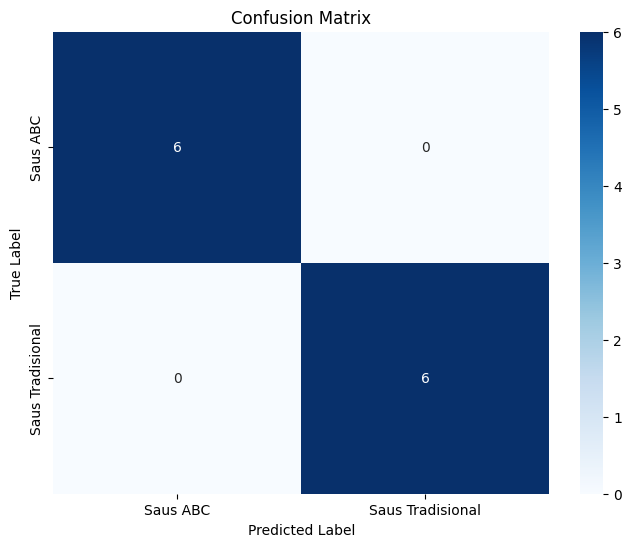

In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

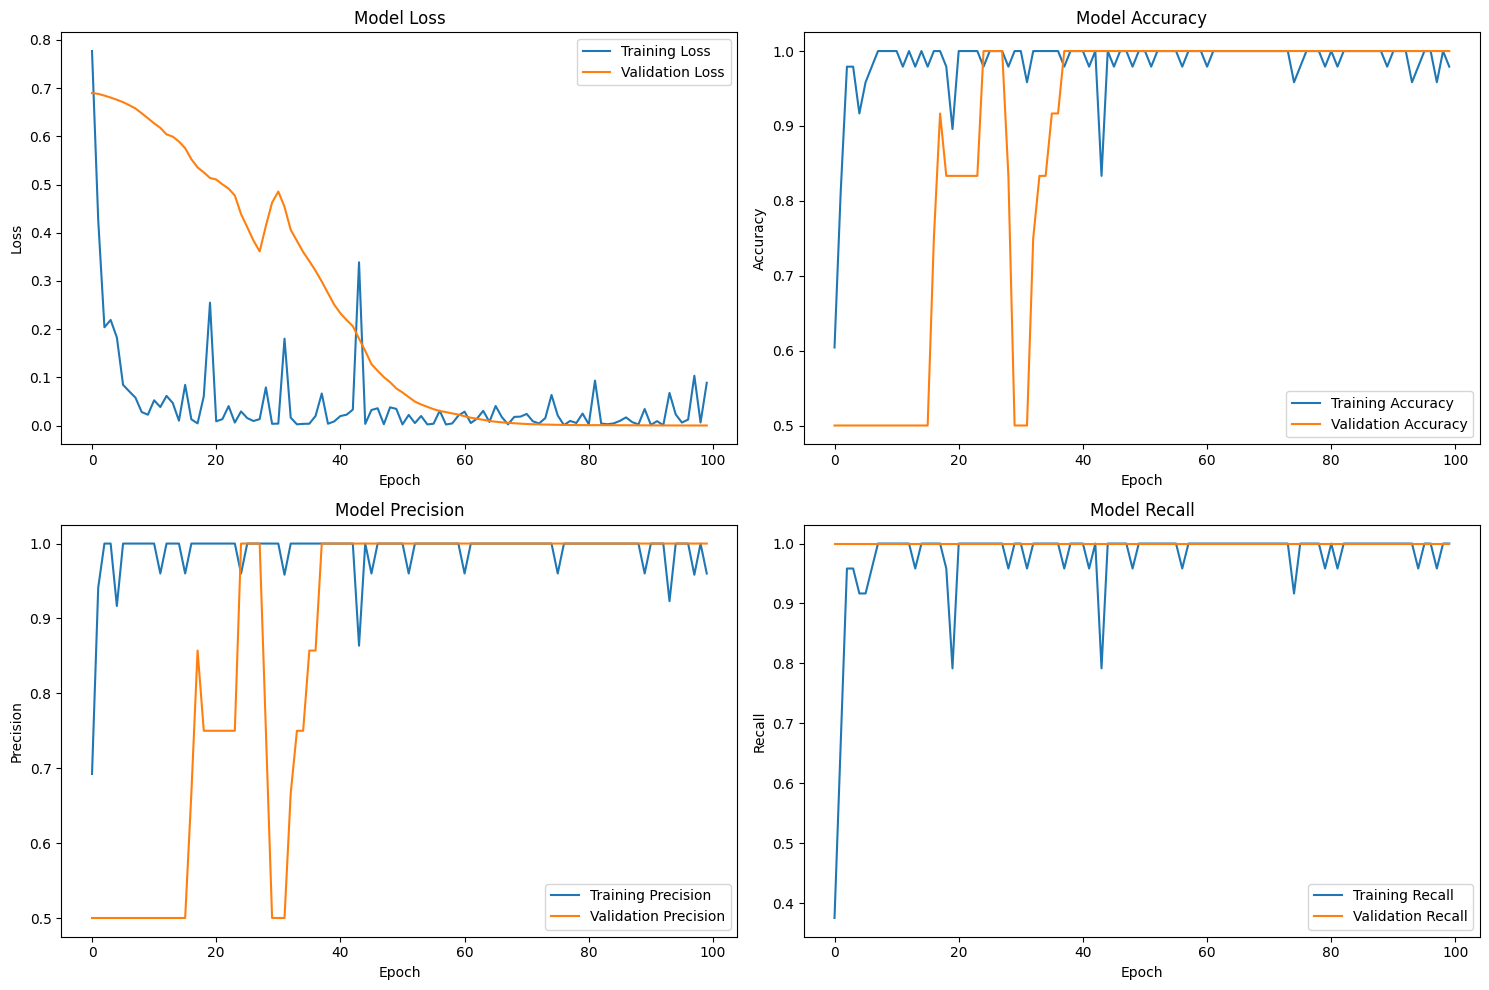

In [39]:
# Training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()